In [1]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from SM141K import SM141K 
from plotAll import generateActiveList, plotTogether
import random
import numpy as np
from IPython.display import display, Image
#import matplotlib.pyplot as plt

duration = 100
time_step = 0.01

> # $ \textbf{\color{black}Model Description} $
* This model is to be used by teams for the GLEE 2022 workshop
* The teams will change parameters that will affect the power and data for each sensor
* The output of this model will be a plot of each sensor's power/data output vs time as well as a plot with all the sensor outputs in a single plot
* A solar model is also included for reference
* All the code for this model is in the .py files and accessed in this file through the import statements at the top of this file
***  


># `Temperature Sensor Configurations`
### General Description:
* "The TMP117 is a high-precision digital temperature sensor"
* It provides a 16-bit temperature result with accuracy of up to $\pm 0.1 ^{\circ}C$ and resolution of $\pm 0.0078 ^{\circ}C$. 
* TMP117 has a programmable EEPROM (electrically erasable programmable read-only memory) and has 48-bits of memory available for general use (section 7.5) 
* The selectable averaging option allows users to configure the device to report the average of multiple temp. conversions. (section 7.3.2)

### Modes info (section 7.4):
> $\text{ One-Shot Mode}$ 
* One-shot mode: After the device completes a (temperature conversion) one-shot conversion, the device goes to the low-power shutdown mode. For OS mode, the conv cycle time is the active time so the possible conv cycle times are only 0.0155, 0.125, 0.5, 1 since there is no standby.   
  
- PARAMS:  
    * Possible conversion cycle times (only first row of Table 7-7): 0.0155, 0.125, 0.5, 1 
    * Possible averaging inputs: 0, 8, 32, 64

> $\text{Continuous Conversion Mode}$
* Continuous conversion mode: The device continuously performs temperature conversions in this mode, as shown in Table 7-7, and updates the temperature result register at the end of every active conversion. The total conversion cycle includes the active conversion time and standby time.  
  
* PARAMS:  
    * Possible conversion cycle times (see Table 7-7 below): 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
    * Possible averaging inputs: 0, 8, 32, 64
   
<center> <img src='convTimes.png' width="700" height="200">  

*Columns represent averaging: 0, 8, 32, 64 (left to right)*  
*Rows represent active conversion time: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16 (from top to bottom)*    
*The numbers inside the table itself represent the total conv cycle time* 
</center> 
    
For additional information:  
https://www.ti.com/lit/ds/symlink/tmp117.pdf?ts=1656974490603&ref_url=https%253A%252F%252Fwww.ti.com%252Ftechnologies%252Finternet-of-things%252Foverview.html 

*** 

#### TO-DO: Change parameters for TMP117 below

In [2]:
activeTimeParams = [(0, 5, "CC_32_16"), (70, 75, "OS_64_1"), (75,100, "OS_32_0.0155")] 

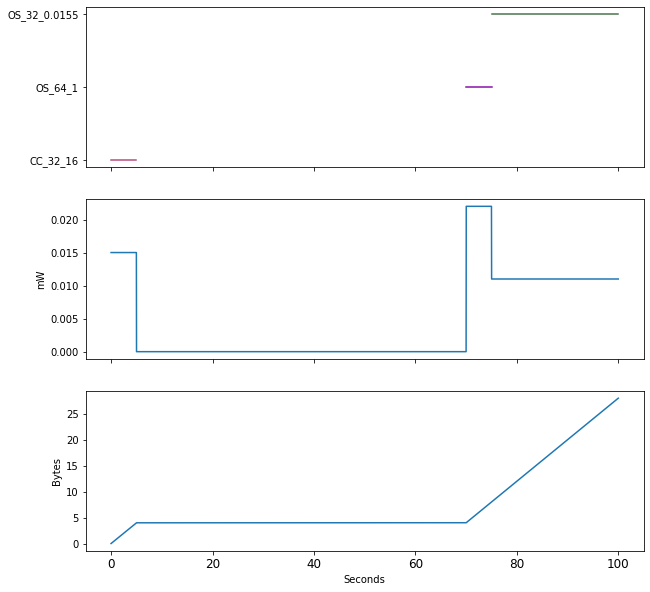

In [3]:
tmp1 = TMP117(time_step, duration, activeTimeParams, loop_rate = 20)
power_tmp, data_tmp, time_tmp= tmp1.runSim(plot=True);

In [4]:
print(power_tmp)

[0.0150711 0.0150711 0.0150711 ... 0.0110492 0.0110492 0.0110492]


*** 

# `Accelerometer Configurations`

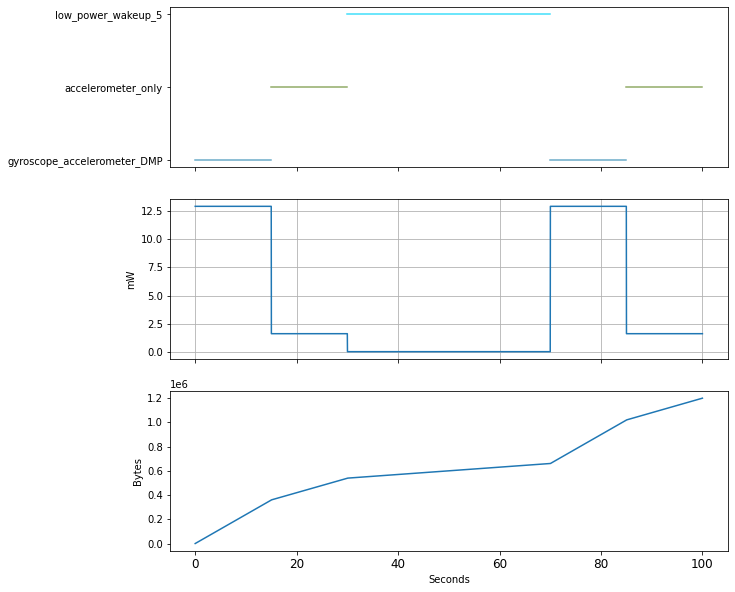

In [5]:
modedict = {"gyroscope_accelerometer_DMP":15, "accelerometer_only":15,"low_power_wakeup_5":40}
active_times = generateActiveList(total_time=100, modedict=modedict)
accel2 = MPU6050(time_step=time_step, duration=duration, loop_rate=20, digital_low_pass=0, sample_rate_divisor=0)

time_acc, power_acc, data_acc = accel2.runSim(active_times)

# `Thermopile Configurations`

The args we pass in to the function is the time_step and duration. As with the active times, we pass in what mode we want the sensro to run on as well as the times we want it to be active. The two possible modes are "TP_only" and "TP_off"

Successful
Successful
Successful


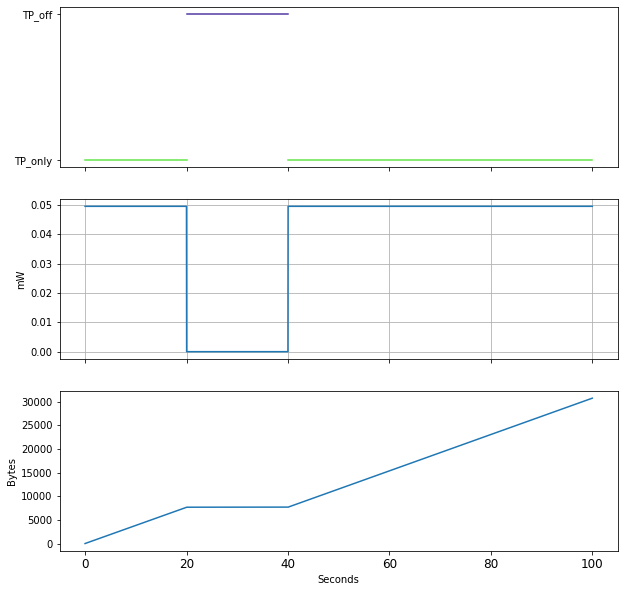

In [6]:
from TP import TP
Thermo = TP(time_step, duration, loop_rate=20)
active_times = [(0,20,"TP_only"), (20,40,"TP_off"), (40,100,"TP_only")]
tp_time, tp_power, tp_data = Thermo.runSim(active_times)

# `Capacitor Configurations`

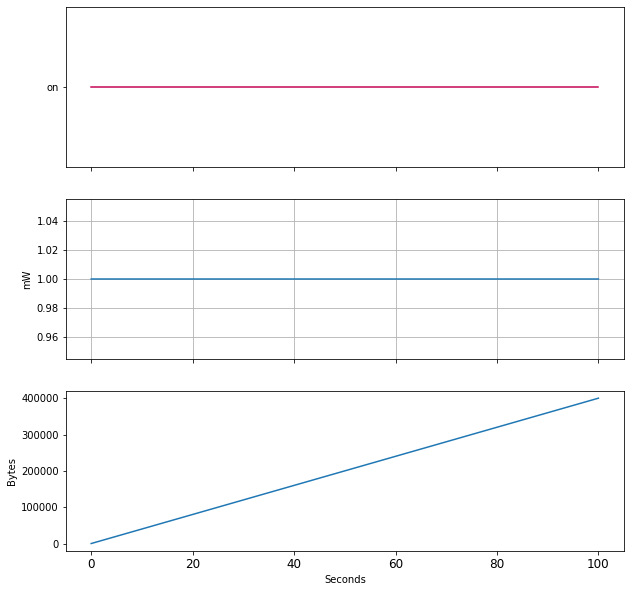

In [7]:
cap = CAP11NA(loop_rate=20, duration=duration, time_step=time_step)
cap_active_times = [(0,100,"on")]
cap_time, cap_power, cap_data = cap.runSim(cap_active_times)

# `Magnetometer Configurations`

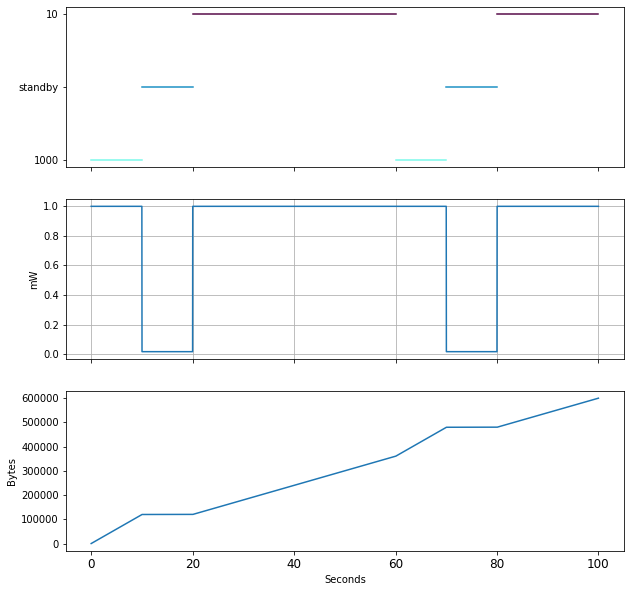

In [8]:
foo = BM1422(loop_rate=20, duration=duration, time_step=time_step)
#for magnetometer, the certain mode is the timing specification, or standby.
modedict = {"1000":10, "standby":10,"10":40}
mag_activetimes = generateActiveList(total_time=duration, modedict=modedict)
mag_time, mag_power, mag_data = foo.runSim(mag_activetimes)

# `Solar Panel Model`

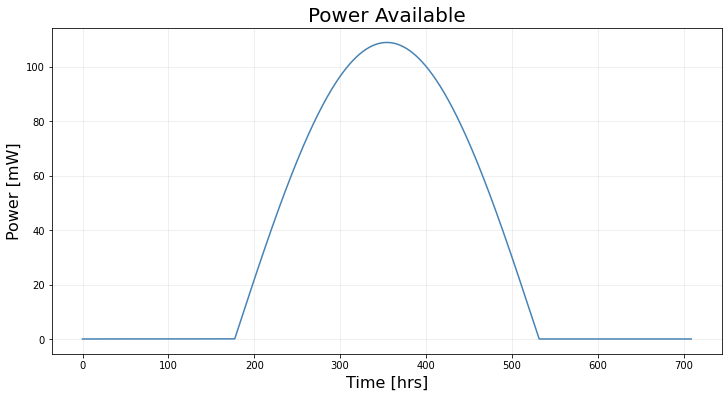

In [9]:
solar_panel_model = SM141K(start_time_hrs=0, duration_hrs=709, time_step_seconds=30, latitude=45)
solar_panel_model.plotPowerAvailable()

# `All Together`

In [10]:
total_pow = power_tmp + mag_power + power_acc + cap_power + tp_power
total_data = data_tmp + mag_data + data_acc + cap_data + tp_data

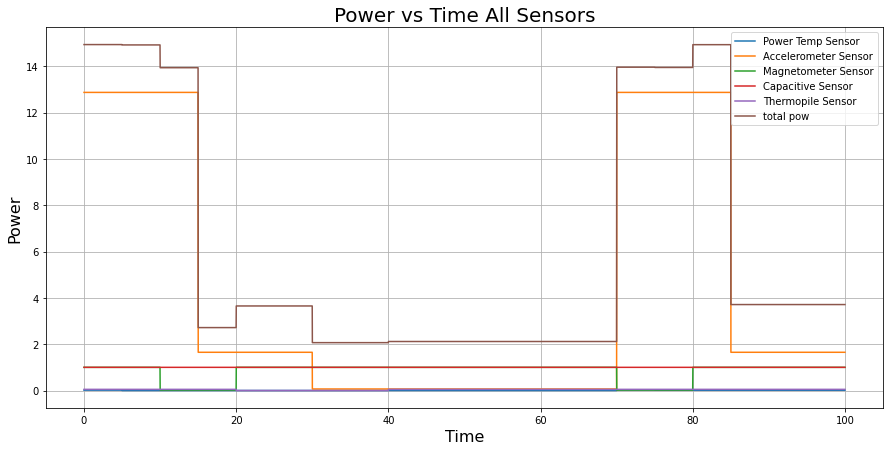

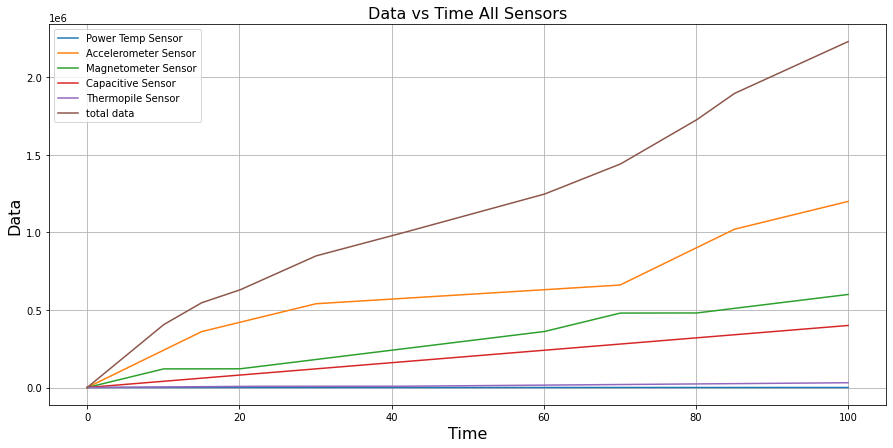

In [11]:
plotTogether(time_tmp, time_acc, tp_time, cap_time, mag_time, tp_power, power_tmp, power_acc, mag_power, cap_power, data_tmp, data_acc, mag_data, cap_data, tp_data, total_pow, total_data)


[192.775, 516.225]

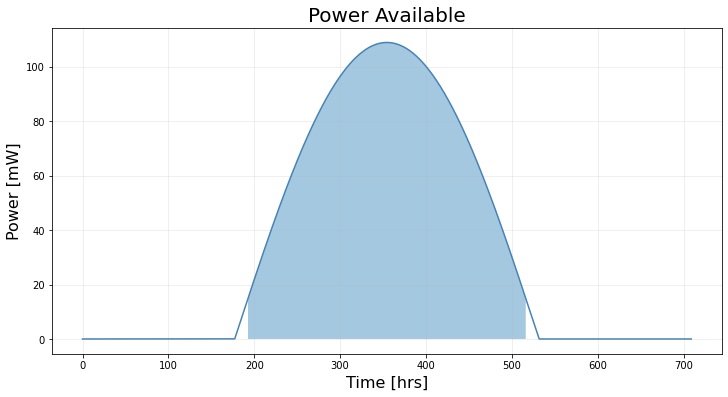

In [13]:
max_power_used = max(total_pow)
solar_panel_model.plotPowerAndTimesPossible(max_power = max_power_used)